In [1]:
import torch, cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

CKPT = "./checkpoints/sam2.1_hiera_large.pt"
CFG  = "configs/sam2.1/sam2.1_hiera_l.yaml"

dev  = "cuda" if torch.cuda.is_available() else "cpu"
sam2 = build_sam2(CFG, CKPT, device=dev).eval()
pred = SAM2ImagePredictor(sam2)

In [40]:
IMG  = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/leather/test/color/000.png")
rgb  = cv2.cvtColor(cv2.imread(str(IMG)), cv2.COLOR_BGR2RGB)
H, W = rgb.shape[:2]
pred.set_image(rgb)

SAM2 raw candidates = 3072
final fg masks   = 2
background mask   = mask 3 (index 3)
coverage = 1.000, mean overlap = 0.048


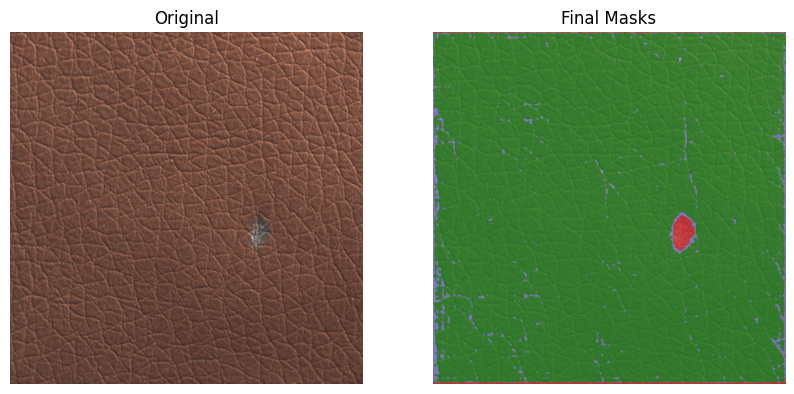

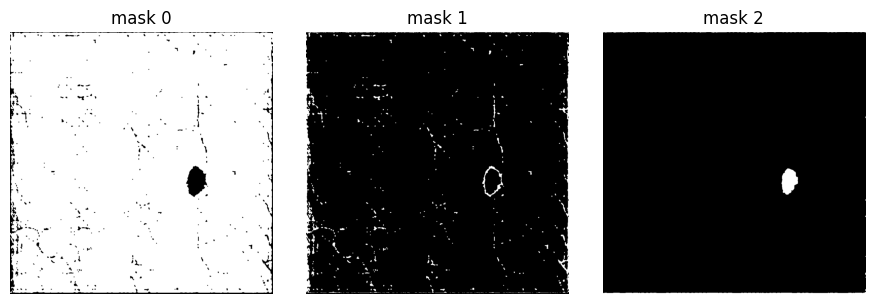

In [41]:
gx, gy = 8, 4
xs, ys = np.linspace(0, W-1, gx), np.linspace(0, H-1, gy)
xv, yv = np.meshgrid(xs, ys)
points = np.stack([xv.ravel(), yv.ravel()], 1).astype(np.float32)
labels = np.ones(points.shape[0], dtype=np.int32)

with torch.inference_mode(), torch.autocast(dev, torch.bfloat16):
    logits, scores, _ = pred.predict(
        point_coords   = points,
        point_labels   = labels,
        multimask_output = True,      
        return_logits    = True
    )                                 

print(f"SAM2 raw candidates = {logits.shape[0] * logits.shape[1]}")

probs  = torch.sigmoid(torch.from_numpy(logits))
thr    = 0.6
bin_m  = (probs > thr).numpy().astype(np.uint8).reshape(-1, H, W)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
clean  = []
for m in bin_m:
    m = cv2.morphologyEx(m*255, cv2.MORPH_OPEN,  kernel)
    m = cv2.morphologyEx(m,      cv2.MORPH_CLOSE, kernel)
    clean.append(m.astype(bool))
masks  = np.stack(clean)                  
scores = scores.flatten()

top3     = np.argsort(-scores)[:3]
fg_raw   = masks[top3]                      
areas    = fg_raw.sum((1,2))
order     = np.argsort(areas)             
occupied  = np.zeros((H,W), bool); fg_final=[]
for idx in order:
    m = np.logical_and(fg_raw[idx], ~occupied)
    if m.sum() >= 1:
        fg_final.append(m); occupied |= m

if occupied.sum() < H * W:     
    bg = ~occupied
    final_masks = fg_final + [bg]
else:
    final_masks = fg_final

print(f"final fg masks   = {len(fg_final)}")
print("background mask   = mask 3 (index 3)")

stack = np.stack(final_masks)              
cov   = stack.sum() / (H*W)

flat  = stack.reshape(4, -1).astype(bool)
inter = (flat[:,None,:] & flat[None,:,:]).sum(-1)
area  = flat.sum(-1, keepdims=True)
iou   = inter / (area + area.T - inter + 1e-6); np.fill_diagonal(iou,0)
print(f"coverage = {cov:.3f}, mean overlap = {iou.mean():.3f}")

palette = np.random.randint(0,255,(4,3))
overlay = rgb.copy()
for c,m in zip(palette, final_masks): overlay[m] = overlay[m]*0.3 + c*0.7

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(rgb);           plt.title("Original");     plt.axis("off")
plt.subplot(1,2,2); plt.imshow(overlay);       plt.title("Final Masks");  plt.axis("off")
plt.show()

plt.figure(figsize=(12,3))
for i, m in enumerate(final_masks):
    plt.subplot(1,4,i+1)
    plt.imshow(m, cmap='gray')
    plt.title(f"mask {i}{' (bg)' if i==3 else ''}")
    plt.axis("off")
plt.tight_layout(); plt.show()

In [42]:
IMG  = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/test/crack/000.png")
rgb  = cv2.cvtColor(cv2.imread(str(IMG)), cv2.COLOR_BGR2RGB)
H, W = rgb.shape[:2]
pred.set_image(rgb)

SAM2 raw candidates = 3072
final fg masks   = 3
background mask   = mask 3 (index 3)
coverage = 1.000, mean overlap = 0.000


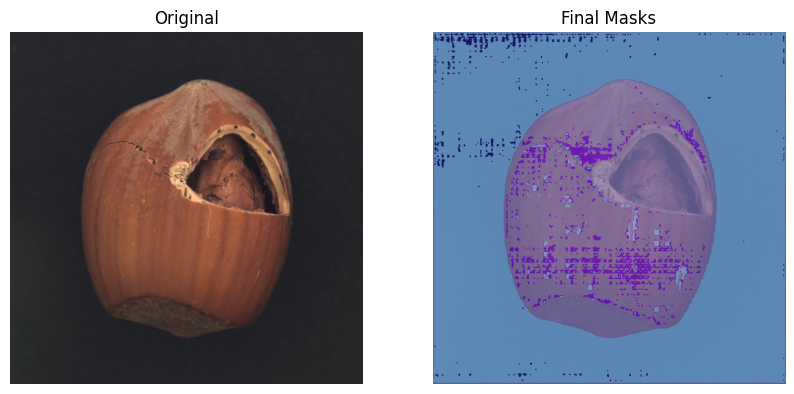

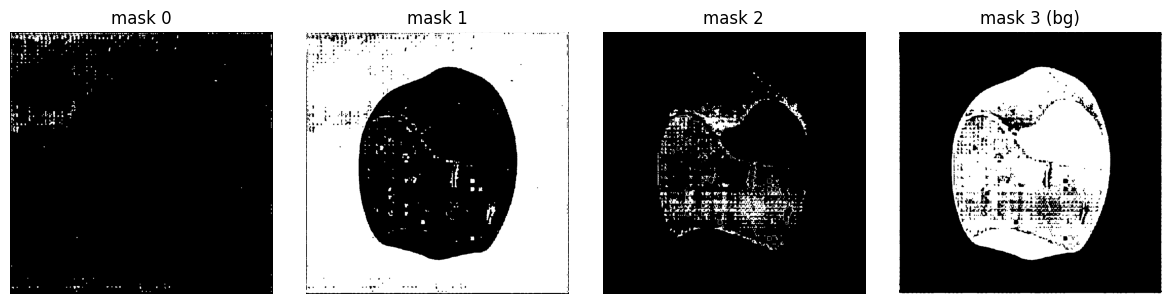

In [45]:
gx, gy = 8, 4
xs, ys = np.linspace(0, W-1, gx), np.linspace(0, H-1, gy)
xv, yv = np.meshgrid(xs, ys)
points = np.stack([xv.ravel(), yv.ravel()], 1).astype(np.float32)
labels = np.ones(points.shape[0], dtype=np.int32)

with torch.inference_mode(), torch.autocast(dev, torch.bfloat16):
    logits, scores, _ = pred.predict(
        point_coords   = points,
        point_labels   = labels,
        multimask_output = True, 
        return_logits    = True
    )                                 

print(f"SAM2 raw candidates = {logits.shape[0] * logits.shape[1]}")

probs  = torch.sigmoid(torch.from_numpy(logits))
thr    = 0.6
bin_m  = (probs > thr).numpy().astype(np.uint8).reshape(-1, H, W)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
clean  = []
for m in bin_m:
    m = cv2.morphologyEx(m*255, cv2.MORPH_OPEN,  kernel)
    m = cv2.morphologyEx(m,      cv2.MORPH_CLOSE, kernel)
    clean.append(m.astype(bool))
masks  = np.stack(clean)                   
scores = scores.flatten()

top3     = np.argsort(-scores)[:3]
fg_raw   = masks[top3]                    
areas    = fg_raw.sum((1,2))
order     = np.argsort(areas)            
occupied  = np.zeros((H,W), bool); fg_final=[]
for idx in order:
    m = np.logical_and(fg_raw[idx], ~occupied)
    if m.any():
        fg_final.append(m); occupied |= m

bg        = ~occupied
final_masks = fg_final + [bg]              

print(f"final fg masks   = {len(fg_final)}")
print("background mask   = mask 3 (index 3)")

stack = np.stack(final_masks)              
cov   = stack.sum() / (H*W)

flat  = stack.reshape(4, -1).astype(bool)
inter = (flat[:,None,:] & flat[None,:,:]).sum(-1)
area  = flat.sum(-1, keepdims=True)
iou   = inter / (area + area.T - inter + 1e-6); np.fill_diagonal(iou,0)
print(f"coverage = {cov:.3f}, mean overlap = {iou.mean():.3f}")

palette = np.random.randint(0,255,(4,3))
overlay = rgb.copy()
for c,m in zip(palette, final_masks): overlay[m] = overlay[m]*0.3 + c*0.7

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(rgb);           plt.title("Original");     plt.axis("off")
plt.subplot(1,2,2); plt.imshow(overlay);       plt.title("Final Masks");  plt.axis("off")
plt.show()

plt.figure(figsize=(12,3))
for i, m in enumerate(final_masks):
    plt.subplot(1,4,i+1)
    plt.imshow(m, cmap='gray')
    plt.title(f"mask {i}{' (bg)' if i==3 else ''}")
    plt.axis("off")
plt.tight_layout(); plt.show()

In [32]:
IMG  = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/bottle/test/broken_large/002.png")
rgb  = cv2.cvtColor(cv2.imread(str(IMG)), cv2.COLOR_BGR2RGB)
H, W = rgb.shape[:2]
pred.set_image(rgb)

SAM2 raw candidates = 2700
final fg masks   = 2
background mask   = mask 3 (index 3)
coverage = 1.000, mean overlap = 0.116


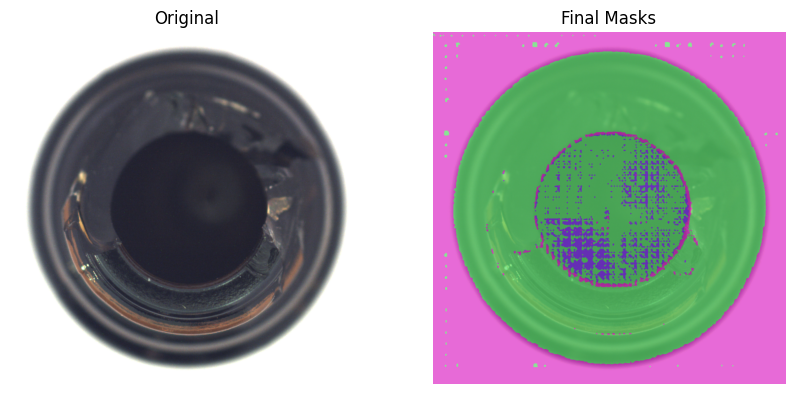

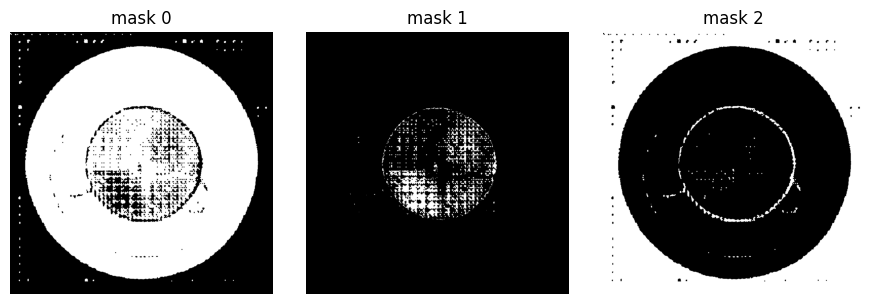

In [34]:
gx, gy = 8, 4
xs, ys = np.linspace(0, W-1, gx), np.linspace(0, H-1, gy)
xv, yv = np.meshgrid(xs, ys)
points = np.stack([xv.ravel(), yv.ravel()], 1).astype(np.float32)
labels = np.ones(points.shape[0], dtype=np.int32)

with torch.inference_mode(), torch.autocast(dev, torch.bfloat16):
    logits, scores, _ = pred.predict(
        point_coords   = points,
        point_labels   = labels,
        multimask_output = True,      
        return_logits    = True
    )                                

print(f"SAM2 raw candidates = {logits.shape[0] * logits.shape[1]}")

probs  = torch.sigmoid(torch.from_numpy(logits))
thr    = 0.6
bin_m  = (probs > thr).numpy().astype(np.uint8).reshape(-1, H, W)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
clean  = []
for m in bin_m:
    m = cv2.morphologyEx(m*255, cv2.MORPH_OPEN,  kernel)
    m = cv2.morphologyEx(m,      cv2.MORPH_CLOSE, kernel)
    clean.append(m.astype(bool))
masks  = np.stack(clean)                    
scores = scores.flatten()

top3     = np.argsort(-scores)[:3]
fg_raw   = masks[top3]                     
areas    = fg_raw.sum((1,2))
order     = np.argsort(areas)              
occupied  = np.zeros((H,W), bool); fg_final=[]
for idx in order:
    m = np.logical_and(fg_raw[idx], ~occupied)
    if m.any():
        fg_final.append(m); occupied |= m

bg        = ~occupied
final_masks = fg_final + [bg]               

print(f"final fg masks   = {len(fg_final)}")
print("background mask   = mask 3 (index 3)")

stack = np.stack(final_masks)              
cov   = stack.sum() / (H*W)

flat  = stack.reshape(4, -1).astype(bool)
inter = (flat[:,None,:] & flat[None,:,:]).sum(-1)
area  = flat.sum(-1, keepdims=True)
iou   = inter / (area + area.T - inter + 1e-6); np.fill_diagonal(iou,0)
print(f"coverage = {cov:.3f}, mean overlap = {iou.mean():.3f}")

palette = np.random.randint(0,255,(4,3))
overlay = rgb.copy()
for c,m in zip(palette, final_masks): overlay[m] = overlay[m]*0.3 + c*0.7

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(rgb);           plt.title("Original");     plt.axis("off")
plt.subplot(1,2,2); plt.imshow(overlay);       plt.title("Final Masks");  plt.axis("off")
plt.show()

plt.figure(figsize=(12,3))
for i, m in enumerate(final_masks):
    plt.subplot(1,4,i+1)
    plt.imshow(m, cmap='gray')
    plt.title(f"mask {i}{' (bg)' if i==3 else ''}")
    plt.axis("off")
plt.tight_layout(); plt.show()

In [35]:
IMG  = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/zipper/test/broken_teeth/001.png")
rgb  = cv2.cvtColor(cv2.imread(str(IMG)), cv2.COLOR_BGR2RGB)
H, W = rgb.shape[:2]
pred.set_image(rgb)

SAM2 raw candidates = 3072
final fg masks   = 2
background mask   = mask 3 (index 3)
coverage = 1.000, mean overlap = 0.086


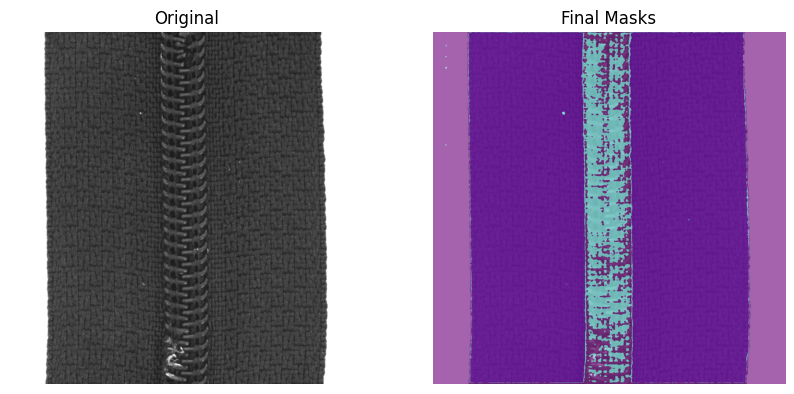

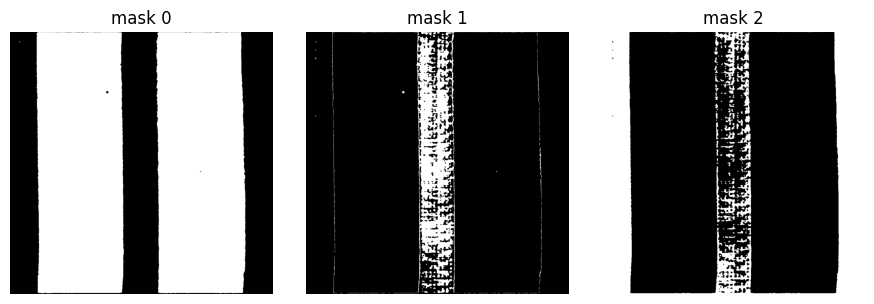

In [37]:
gx, gy = 8, 4
xs, ys = np.linspace(0, W-1, gx), np.linspace(0, H-1, gy)
xv, yv = np.meshgrid(xs, ys)
points = np.stack([xv.ravel(), yv.ravel()], 1).astype(np.float32)
labels = np.ones(points.shape[0], dtype=np.int32)

with torch.inference_mode(), torch.autocast(dev, torch.bfloat16):
    logits, scores, _ = pred.predict(
        point_coords   = points,
        point_labels   = labels,
        multimask_output = True,      
        return_logits    = True
    )                                 

print(f"SAM2 raw candidates = {logits.shape[0] * logits.shape[1]}")

probs  = torch.sigmoid(torch.from_numpy(logits))
thr    = 0.6
bin_m  = (probs > thr).numpy().astype(np.uint8).reshape(-1, H, W)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
clean  = []
for m in bin_m:
    m = cv2.morphologyEx(m*255, cv2.MORPH_OPEN,  kernel)
    m = cv2.morphologyEx(m,      cv2.MORPH_CLOSE, kernel)
    clean.append(m.astype(bool))
masks  = np.stack(clean)                    
scores = scores.flatten()

top3     = np.argsort(-scores)[:3]
fg_raw   = masks[top3]                      
areas    = fg_raw.sum((1,2))
order     = np.argsort(areas)               
occupied  = np.zeros((H,W), bool); fg_final=[]
for idx in order:
    m = np.logical_and(fg_raw[idx], ~occupied)
    if m.any():
        fg_final.append(m); occupied |= m

bg        = ~occupied
final_masks = fg_final + [bg]               

print(f"final fg masks   = {len(fg_final)}")
print("background mask   = mask 3 (index 3)")

stack = np.stack(final_masks)              
cov   = stack.sum() / (H*W)

flat  = stack.reshape(4, -1).astype(bool)
inter = (flat[:,None,:] & flat[None,:,:]).sum(-1)
area  = flat.sum(-1, keepdims=True)
iou   = inter / (area + area.T - inter + 1e-6); np.fill_diagonal(iou,0)
print(f"coverage = {cov:.3f}, mean overlap = {iou.mean():.3f}")

palette = np.random.randint(0,255,(4,3))
overlay = rgb.copy()
for c,m in zip(palette, final_masks): overlay[m] = overlay[m]*0.3 + c*0.7

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(rgb);           plt.title("Original");     plt.axis("off")
plt.subplot(1,2,2); plt.imshow(overlay);       plt.title("Final Masks");  plt.axis("off")
plt.show()

plt.figure(figsize=(12,3))
for i, m in enumerate(final_masks):
    plt.subplot(1,4,i+1)
    plt.imshow(m, cmap='gray')
    plt.title(f"mask {i}{' (bg)' if i==3 else ''}")
    plt.axis("off")
plt.tight_layout(); plt.show()

# # 중복되는 영역을 삭제하는 코드를 작성함으로써 중복이 없다는 것을 증명

In [1]:
import torch, cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

CKPT = "./checkpoints/sam2.1_hiera_large.pt"
CFG  = "configs/sam2.1/sam2.1_hiera_l.yaml"

dev  = "cuda" if torch.cuda.is_available() else "cpu"
sam2 = build_sam2(CFG, CKPT, device=dev).eval()
pred = SAM2ImagePredictor(sam2)

In [2]:
IMG  = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/zipper/test/broken_teeth/001.png")
rgb  = cv2.cvtColor(cv2.imread(str(IMG)), cv2.COLOR_BGR2RGB)
H, W = rgb.shape[:2]
pred.set_image(rgb)

In [4]:
gx, gy = 8, 4
xs, ys = np.linspace(0, W-1, gx), np.linspace(0, H-1, gy)
xv, yv = np.meshgrid(xs, ys)
points = np.stack([xv.ravel(), yv.ravel()], 1).astype(np.float32)
labels = np.ones(points.shape[0], dtype=np.int32)

with torch.inference_mode(), torch.autocast(dev, torch.bfloat16):
    masks, scores, logits = pred.predict(
        point_coords    = points,
        point_labels    = labels,
        multimask_output= True,    
        return_logits   = True
    )                              
print(f"SAM2 raw candidates = {masks.size//(H*W)}")  

SAM2 raw candidates = 3


In [ ]:
keep   = scores.flatten() >= 0.90          
masks  = masks.reshape(-1, H, W)[keep]     
scores_f = scores.flatten()[keep]          

top3    = np.argsort(-scores_f)[:3]
fg_raw  = bin_m[top3]                      
areas   = fg_raw.sum((1,2))
order   = np.argsort(areas)               
occupied= np.zeros((H,W), bool); fg_final=[]
for idx in order:
    m = np.logical_and(fg_raw[idx], ~occupied)
    if m.any():
        fg_final.append(m); occupied |= m

if occupied.sum() < H*W:                   
    bg = ~occupied
    final_masks = fg_final + [bg]
else:
    final_masks = fg_final

print(f"final fg masks = {len(fg_final)},  background added {len(final_masks)==4}")

fg_stack = np.stack(fg_final)
flat_fg  = fg_stack.reshape(len(fg_final), -1)
inter    = (flat_fg[:,None,:] & flat_fg[None,:,:]).sum(-1)
area_fg  = flat_fg.sum(-1, keepdims=True)
iou_fg   = inter / (area_fg + area_fg.T - inter + 1e-6); np.fill_diagonal(iou_fg,0)

coverage = np.stack(final_masks).sum() / (H*W)
print(f"coverage = {coverage:.3f}, mean FG-overlap = {iou_fg.mean():.6f}")

palette = np.random.randint(0,255,(len(final_masks),3))
overlay = rgb.copy()
for c,m in zip(palette, final_masks): overlay[m] = overlay[m]*0.3 + c*0.7

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(rgb);           plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(overlay);       plt.title("Final Masks"); plt.axis("off")
plt.show()

plt.figure(figsize=(12,3))
for i,m in enumerate(final_masks):
    plt.subplot(1,len(final_masks),i+1)
    plt.imshow(m,cmap='gray')
    plt.title(f"mask {i}{' (bg)' if len(final_masks)==4 and i==3 else ''}")
    plt.axis("off")
plt.tight_layout(); plt.show()

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
․ 목적: SAM 2가 MVTec-AD 이미지에서 추출한 마스크를 시각화하고
        ․ coverage(픽셀 덮음 비율)
        ․ pairwise IoU(마스크 간 겹침)
      지표를 계산한다.
․ 환경: CUDA + bfloat16 자동 캐스팅
"""

# ────────────────────────────── 1. 라이브러리 ──────────────────────────────
import torch, cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sam2.build_sam import build_sam2                 # SAM2 core
from sam2.sam2_image_predictor import SAM2ImagePredictor

# ────────────────────────────── 2. 경로 설정 ───────────────────────────────
CKPT_PATH = "./checkpoints/sam2.1_hiera_large.pt"
CFG_PATH  = "configs/sam2.1/sam2.1_hiera_l.yaml"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] device  = {device}")

# ────────────────────────────── 3. 모델 로딩 ───────────────────────────────
sam2 = build_sam2(CFG_PATH, CKPT_PATH, device=device)   # 내부에서 .to(device)
sam2.eval()                                             # **모델**만 eval

predictor = SAM2ImagePredictor(sam2)                    # .to()·.eval() 불필요

[INFO] device  = cuda


In [2]:
IMG_PATH  = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/grid/test/bent/000.png")

[INFO] 마스크 개수 = 3
[METRIC] coverage      = 1.315
[METRIC] 평균 IoU 겹침 = 0.081


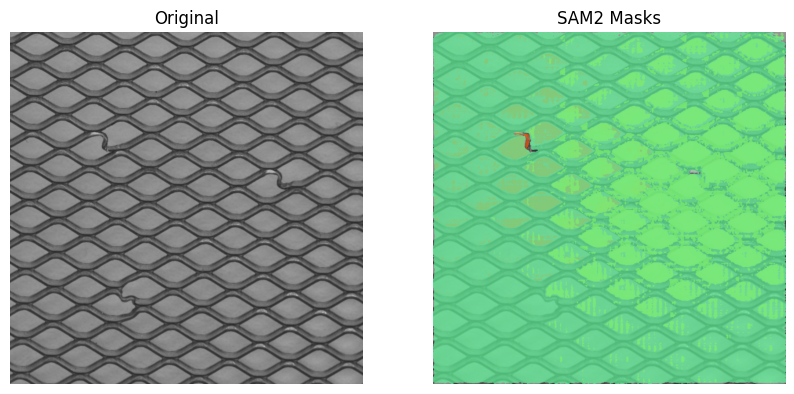

In [7]:
# ────────────────────────────── 4. 이미지 준비 ─────────────────────────────
img_bgr = cv2.imread(str(IMG_PATH))
assert img_bgr is not None, "이미지 경로를 확인하세요."
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
predictor.set_image(img_rgb)                            # H×W×3, RGB

# ────────────────────────────── 5. 마스크 예측 ─────────────────────────────
with torch.inference_mode(), torch.autocast(device_type="cuda", dtype=torch.bfloat16):
    masks, iou_preds, low_res_masks = predictor.predict(
        None,
        multimask_output=True,
        return_logits=False
    )          # masks: (N, H, W) ndarray  *or* torch.Tensor

# ────────────────────────────── 6. 지표 계산 ───────────────────────────────
if isinstance(masks, torch.Tensor):             # GPU/CPU tensor
    masks_np = masks.detach().cpu().numpy().astype(bool)
else:                                           # already ndarray
    masks_np = masks.astype(bool)

N, H, W = masks_np.shape
print(f"[INFO] 마스크 개수 = {N}")

flat = masks_np.reshape(N, -1)                          # (N, H·W)
inter = (flat[:, None] & flat).sum(-1)                  # (N, N)
area  = flat.sum(-1, keepdims=True)                     # (N, 1)
iou_mat = inter / (area + area.T - inter + 1e-6)
np.fill_diagonal(iou_mat, 0)

coverage = flat.sum() / (H * W)                         # 0~1
mean_overlap = iou_mat.mean()

print(f"[METRIC] coverage      = {coverage:.3f}")       # 전체 픽셀 중 덮인 비율
print(f"[METRIC] 평균 IoU 겹침 = {mean_overlap:.3f}")   # 마스크 간 평균 겹침

# ────────────────────────────── 7. 시각화 ──────────────────────────────────
overlay = img_rgb.copy()
palette = np.random.randint(0, 255, size=(N, 3))
for idx, m in enumerate(masks_np):
    overlay[m] = overlay[m] * 0.3 + palette[idx] * 0.7

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.title("Original");       plt.imshow(img_rgb); plt.axis("off")
plt.subplot(1, 2, 2); plt.title("SAM2 Masks");     plt.imshow(overlay.astype(np.uint8)); plt.axis("off")
plt.show()

[TRY] {'points_per_side': 64, 'pred_iou_thresh': 0.88, 'box_nms_thresh': 0.15} → coverage=0.551, overlap=0.000, N=2
[TRY] {'points_per_side': 96, 'pred_iou_thresh': 0.9, 'box_nms_thresh': 0.1} → coverage=0.553, overlap=0.000, N=2
[INFO] background mask 추가
[BEST] coverage=1.000, overlap=0.000, N=3


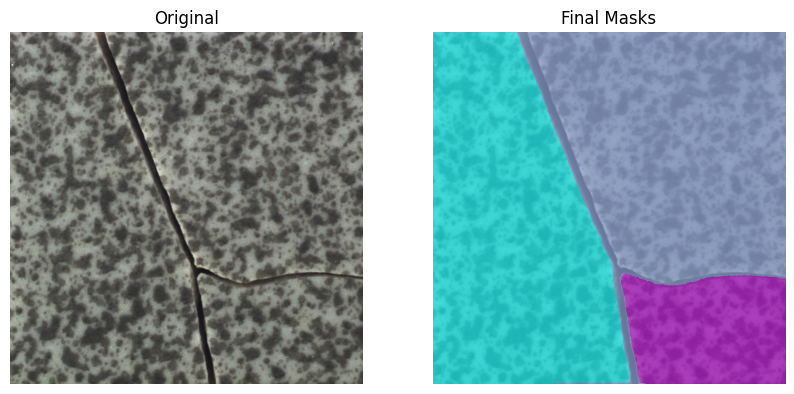

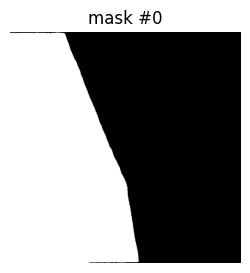

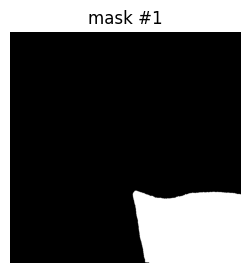

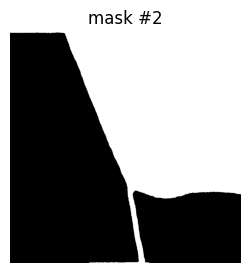

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
SAM-2                           ▶ 마스크 생성(AMG)
                                 ▶ 지표 계산(coverage·mean IoU)
                                 ▶ 부족 시 파라미터 ↑
                                 ▶ 여전히 부족하면 background mask 추가
                                 ▶ 시각화 실시간 확인
"""

# ─────────────── 1. 라이브러리 ───────────────
import torch, cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path, PurePath
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# ─────────────── 2. 유틸 함수 ───────────────
def calc_metrics(mask_list, H, W):
    """mask_list = list[np.ndarray bool H×W]"""
    stack = np.stack(mask_list)               # (N, H, W)
    flat  = stack.reshape(len(stack), -1)     # (N, H·W)
    inter = (flat[:, None] & flat).sum(-1)
    area  = flat.sum(-1, keepdims=True)
    iou   = inter / (area + area.T - inter + 1e-6)
    np.fill_diagonal(iou, 0)
    coverage     = flat.sum() / (H * W)
    mean_overlap = iou.mean()
    return coverage, mean_overlap

def vis_overlay(img_rgb, mask_list, title="Overlay"):
    palette = np.random.randint(0, 255, size=(len(mask_list), 3))
    overlay = img_rgb.copy()
    for idx, m in enumerate(mask_list):
        overlay[m] = overlay[m] * 0.3 + palette[idx] * 0.7
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1); plt.title("Original"); plt.imshow(img_rgb); plt.axis("off")
    plt.subplot(1,2,2); plt.title(title);     plt.imshow(overlay);  plt.axis("off")
    plt.show()

# ─────────────── 3. 경로 · 모델 ───────────────
IMG_PATH  = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/tile/test/crack/000.png")
CKPT_PATH = "./checkpoints/sam2.1_hiera_large.pt"
CFG_PATH  = "configs/sam2.1/sam2.1_hiera_l.yaml"

device = "cuda" if torch.cuda.is_available() else "cpu"
sam2   = build_sam2(CFG_PATH, CKPT_PATH, device=device).eval()

# ─────────────── 4. 이미지 로드 ───────────────
img_bgr = cv2.imread(str(IMG_PATH)); assert img_bgr is not None
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
H, W, _ = img_rgb.shape

# ─────────────── 5. 파라미터 시도 표 ──────────
search_grid = [
    dict(points_per_side=64, pred_iou_thresh=0.88, box_nms_thresh=0.15),
    dict(points_per_side=96, pred_iou_thresh=0.90, box_nms_thresh=0.10),
]

best_masks, best_cov, best_ov = None, 0, 1
for conf in search_grid:
    amg = SAM2AutomaticMaskGenerator(
        model=sam2,
        min_mask_region_area=256,
        stability_score_thresh=0.95,
        **conf
    )
    masks_info = amg.generate(img_rgb)
    masks_seg  = [m["segmentation"].astype(bool) for m in masks_info]
    cov, ov    = calc_metrics(masks_seg, H, W)
    print(f"[TRY] {conf} → coverage={cov:.3f}, overlap={ov:.3f}, N={len(masks_seg)}")

    if cov > best_cov or (cov == best_cov and ov < best_ov):
        best_masks, best_cov, best_ov = masks_seg, cov, ov

# ─────────────── 6. background 보강 ────────────
if best_cov < 0.999:                          # 0.999 ⇒ 사실상 빈 픽셀
    union = np.logical_or.reduce(best_masks)  # (H, W)
    bg    = ~union
    if bg.sum():
        best_masks.append(bg)
        best_cov, best_ov = calc_metrics(best_masks, H, W)
        print("[INFO] background mask 추가")

print(f"[BEST] coverage={best_cov:.3f}, overlap={best_ov:.3f}, N={len(best_masks)}")

# ─────────────── 7. 시각화 ───────────────
vis_overlay(img_rgb, best_masks, title="Final Masks")

# ─────────────── 8. 개별 마스크 확인 루프 ──────
for idx, m in enumerate(best_masks):
    plt.figure(figsize=(3,3)); plt.imshow(m, cmap="gray"); plt.title(f"mask #{idx}"); plt.axis("off"); plt.show()


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
SAM-2                           ▶ 마스크 생성(AMG)
                                 ▶ 지표 계산(coverage·mean IoU)
                                 ▶ 부족 시 파라미터 ↑
                                 ▶ 여전히 부족하면 background mask 추가
                                 ▶ 시각화 실시간 확인
"""

# ─────────────── 1. 라이브러리 ───────────────
import torch, cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path, PurePath
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# ─────────────── 2. 유틸 함수 ───────────────
def calc_metrics(mask_list, H, W):
    """mask_list = list[np.ndarray bool H×W]"""
    stack = np.stack(mask_list)               # (N, H, W)
    flat  = stack.reshape(len(stack), -1)     # (N, H·W)
    inter = (flat[:, None] & flat).sum(-1)
    area  = flat.sum(-1, keepdims=True)
    iou   = inter / (area + area.T - inter + 1e-6)
    np.fill_diagonal(iou, 0)
    coverage     = flat.sum() / (H * W)
    mean_overlap = iou.mean()
    return coverage, mean_overlap

def vis_overlay(img_rgb, mask_list, title="Overlay"):
    palette = np.random.randint(0, 255, size=(len(mask_list), 3))
    overlay = img_rgb.copy()
    for idx, m in enumerate(mask_list):
        overlay[m] = overlay[m] * 0.3 + palette[idx] * 0.7
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1); plt.title("Original"); plt.imshow(img_rgb); plt.axis("off")
    plt.subplot(1,2,2); plt.title(title);     plt.imshow(overlay);  plt.axis("off")
    plt.show()

# ─────────────── 3. 경로 · 모델 ───────────────
IMG_PATH  = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/tile/test/crack/000.png")
CKPT_PATH = "./checkpoints/sam2.1_hiera_large.pt"
CFG_PATH  = "configs/sam2.1/sam2.1_hiera_l.yaml"

device = "cuda" if torch.cuda.is_available() else "cpu"
sam2   = build_sam2(CFG_PATH, CKPT_PATH, device=device).eval()

# ─────────────── 4. 이미지 로드 ───────────────
img_bgr = cv2.imread(str(IMG_PATH)); assert img_bgr is not None
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
H, W, _ = img_rgb.shape

# ─────────────── 5. 파라미터 시도 표 ──────────
search_grid = [
    dict(points_per_side=64, pred_iou_thresh=0.88, box_nms_thresh=0.15),
    dict(points_per_side=96, pred_iou_thresh=0.90, box_nms_thresh=0.10),
]

best_masks, best_cov, best_ov = None, 0, 1
for conf in search_grid:
    amg = SAM2AutomaticMaskGenerator(
        model=sam2,
        min_mask_region_area=256,
        stability_score_thresh=0.95,
        **conf
    )
    masks_info = amg.generate(img_rgb)
    masks_seg  = [m["segmentation"].astype(bool) for m in masks_info]
    cov, ov    = calc_metrics(masks_seg, H, W)
    print(f"[TRY] {conf} → coverage={cov:.3f}, overlap={ov:.3f}, N={len(masks_seg)}")

    if cov > best_cov or (cov == best_cov and ov < best_ov):
        best_masks, best_cov, best_ov = masks_seg, cov, ov

# ─────────────── 6. background 보강 ────────────
if best_cov < 0.999:                          # 0.999 ⇒ 사실상 빈 픽셀
    union = np.logical_or.reduce(best_masks)  # (H, W)
    bg    = ~union
    if bg.sum():
        best_masks.append(bg)
        best_cov, best_ov = calc_metrics(best_masks, H, W)
        print("[INFO] background mask 추가")

print(f"[BEST] coverage={best_cov:.3f}, overlap={best_ov:.3f}, N={len(best_masks)}")

# ─────────────── 7. 시각화 ───────────────
vis_overlay(img_rgb, best_masks, title="Final Masks")

# ─────────────── 8. 개별 마스크 확인 루프 ──────
for idx, m in enumerate(best_masks):
    plt.figure(figsize=(3,3)); plt.imshow(m, cmap="gray"); plt.title(f"mask #{idx}"); plt.axis("off"); plt.show()


[RESULT] masks=4, coverage=1.000, overlap=0.000


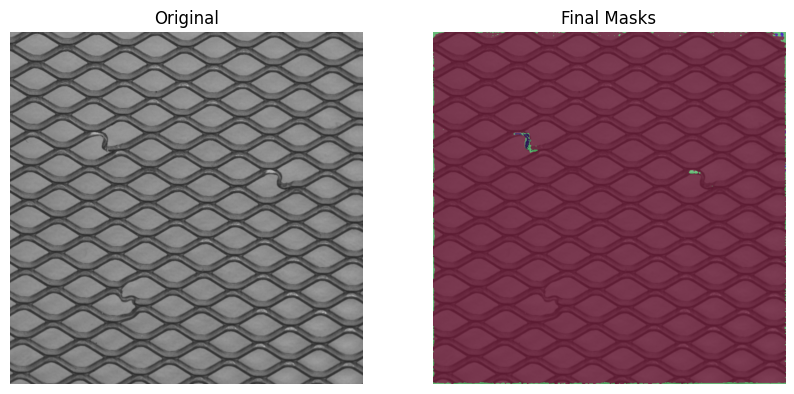

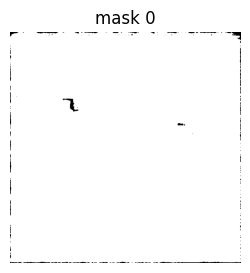

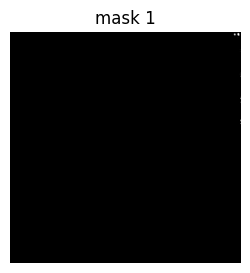

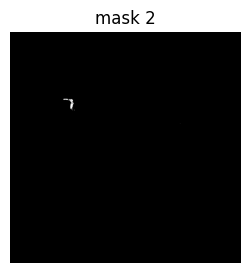

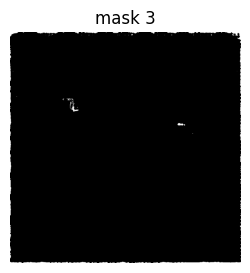

In [5]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import torch, cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# ── 1. 경로 ─────────────────────────────────────────
IMG_PATH  = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/grid/test/bent/000.png")
CKPT_PATH = "./checkpoints/sam2.1_hiera_large.pt"
CFG_PATH  = "configs/sam2.1/sam2.1_hiera_l.yaml"

device = "cuda" if torch.cuda.is_available() else "cpu"
sam2   = build_sam2(CFG_PATH, CKPT_PATH, device=device).eval()
predictor = SAM2ImagePredictor(sam2)

# ── 2. 이미지 입력 ──────────────────────────────────
img_bgr = cv2.imread(str(IMG_PATH)); assert img_bgr is not None
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
H, W, _ = img_rgb.shape
predictor.set_image(img_rgb)

# ── 3. 마스크 후보 추출 (기본 설정) ──────────────────
with torch.inference_mode(), torch.autocast(device_type="cuda", dtype=torch.bfloat16):
    masks, iou_scores, _ = predictor.predict(None, multimask_output=True)  # (N,3,H,W)

# flattens
masks_np   = masks if isinstance(masks, np.ndarray) else masks.cpu().numpy()
scores_np  = iou_scores if isinstance(iou_scores, np.ndarray) else iou_scores.cpu().numpy()
masks_np   = masks_np.reshape(-1, H, W)          # (N·3, H, W)
scores_np  = scores_np.flatten()                 # (N·3,)

# ── 4. 겹침 제거 라스터화 ─────────────────────────────
order = np.argsort(-scores_np)                   # high→low
occupied = np.zeros((H, W), dtype=bool)
final_masks = []
MIN_PIXELS  = 128                                # 너무 작은 파편 제거

for idx in order:
    m = np.logical_and(masks_np[idx], ~occupied)
    if m.sum() >= MIN_PIXELS:
        final_masks.append(m)
        occupied |= m

# ── 5. background mask 추가 (coverage 보장) ──────────
bg = ~occupied
if bg.sum() >= MIN_PIXELS:
    final_masks.append(bg)

# ── 6. 지표 계산 ─────────────────────────────────────
stack = np.stack(final_masks)
flat  = stack.reshape(len(stack), -1)
coverage = flat.sum() / (H * W)
inter  = (flat[:, None] & flat).sum(-1)
area   = flat.sum(-1, keepdims=True)
iou    = inter / (area + area.T - inter + 1e-6); np.fill_diagonal(iou, 0)
mean_overlap = iou.mean()

print(f"[RESULT] masks={len(final_masks)}, coverage={coverage:.3f}, overlap={mean_overlap:.3f}")

# ── 7. 시각화 (개별 + 오버레이) ───────────────────────
palette = np.random.randint(0, 255, size=(len(final_masks), 3))
overlay = img_rgb.copy()
for i, m in enumerate(final_masks): overlay[m] = overlay[m]*0.3 + palette[i]*0.7

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title("Original"); plt.imshow(img_rgb); plt.axis("off")
plt.subplot(1,2,2); plt.title("Final Masks"); plt.imshow(overlay); plt.axis("off")
plt.show()

for i, m in enumerate(final_masks):
    plt.figure(figsize=(3,3)); plt.imshow(m, cmap="gray"); plt.title(f"mask {i}"); plt.axis("off"); plt.show()


[RESULT] masks=4, coverage=1.000, mean IoU=0.000


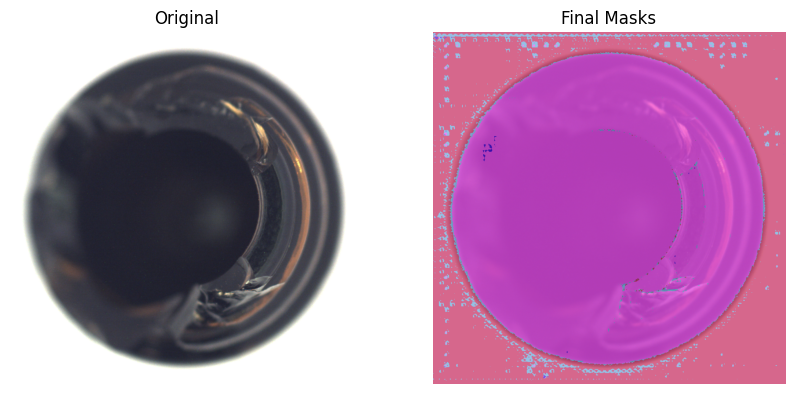

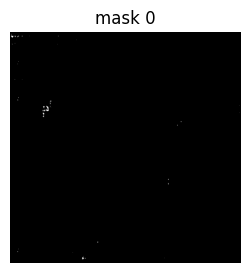

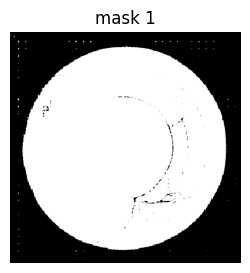

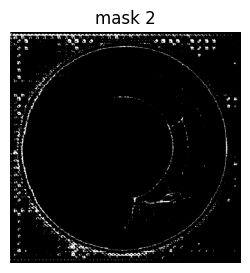

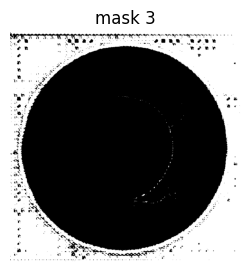

In [6]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
목표
  • SAM-2 기본 파라미터 + 32-point prompt
  • 작은 마스크부터 겹침 제거 → anomaly 영역 우선 보존
  • 빈 픽셀은 background mask 추가 → coverage = 1.0
  • 지표(coverage·mean IoU)·시각화를 즉시 확인
"""

# ───────────────────── 1. 라이브러리 ─────────────────────
import torch, cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# ───────────────────── 2. 경로 · 모델 ────────────────────
IMG_PATH  = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/bottle/test/broken_large/003.png")
CKPT_PATH = "./checkpoints/sam2.1_hiera_large.pt"
CFG_PATH  = "configs/sam2.1/sam2.1_hiera_l.yaml"

device = "cuda" if torch.cuda.is_available() else "cpu"
sam2   = build_sam2(CFG_PATH, CKPT_PATH, device=device).eval()
predictor = SAM2ImagePredictor(sam2)

# ───────────────────── 3. 이미지 ─────────────────────────
img_bgr = cv2.imread(str(IMG_PATH)); assert img_bgr is not None
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
H, W, _ = img_rgb.shape
predictor.set_image(img_rgb)

# ───────────────────── 4. 32-Point Prompt ────────────────
GRID_X, GRID_Y = 8, 4                             # 8×4 = 32
xs = np.linspace(0, W - 1, GRID_X)
ys = np.linspace(0, H - 1, GRID_Y)
xv, yv = np.meshgrid(xs, ys)
point_coords = np.stack([xv.flatten(), yv.flatten()], axis=1).astype(np.float32)
point_labels = np.ones(point_coords.shape[0], dtype=np.int32)    # all positive

# ───────────────────── 5. 마스크 예측 ────────────────────
with torch.inference_mode(), torch.autocast(device_type="cuda", dtype=torch.bfloat16):
    masks, scores, _ = predictor.predict(
        point_coords=point_coords,
        point_labels=point_labels,
        multimask_output=True          # 3 masks/point
    )
masks_np  = masks if isinstance(masks, np.ndarray) else masks.cpu().numpy()
scores_np = scores if isinstance(scores, np.ndarray) else scores.cpu().numpy()
masks_np  = masks_np.reshape(-1, H, W)             # (32×3, H, W)
scores_np = scores_np.flatten()

# ───────────────────── 6. 겹침 제거 (작은 것부터) ────────
areas  = masks_np.sum(axis=(1,2))
order  = np.argsort(areas)                         # asc: small → large
occupied = np.zeros((H, W), dtype=bool)
final_masks = []
MIN_PIXELS  = 128                                  # noise filter

for idx in order:
    m = np.logical_and(masks_np[idx], ~occupied)
    if m.sum() >= MIN_PIXELS:
        final_masks.append(m)
        occupied |= m                              # mark pixels as taken

# ───────────────────── 7. background mask 추가 ───────────
bg = ~occupied
if bg.sum() >= MIN_PIXELS:
    final_masks.append(bg)

# ───────────────────── 8. 지표 계산 ──────────────────────
stack = np.stack(final_masks)                      # (N, H, W)
flat  = stack.reshape(len(stack), -1)
cov   = flat.sum() / (H * W)
inter = (flat[:, None] & flat).sum(-1)
area  = flat.sum(-1, keepdims=True)
iou   = inter / (area + area.T - inter + 1e-6); np.fill_diagonal(iou, 0)
mean_ov = iou.mean()
print(f"[RESULT] masks={len(final_masks)}, coverage={cov:.3f}, mean IoU={mean_ov:.3f}")

# ───────────────────── 9. 시각화 ─────────────────────────
palette = np.random.randint(0, 255, size=(len(final_masks), 3))
overlay = img_rgb.copy()
for i, m in enumerate(final_masks):
    overlay[m] = overlay[m]*0.3 + palette[i]*0.7

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title("Original"); plt.imshow(img_rgb); plt.axis("off")
plt.subplot(1,2,2); plt.title("Final Masks"); plt.imshow(overlay.astype(np.uint8)); plt.axis("off")
plt.show()

for i, m in enumerate(final_masks):
    plt.figure(figsize=(3,3)); plt.imshow(m, cmap="gray"); plt.title(f"mask {i}"); plt.axis("off"); plt.show()


[INFO] final masks = 4 (fg 3 + bg 1)
[METRIC] coverage      = 1.000
[METRIC] mean overlap  = 0.000


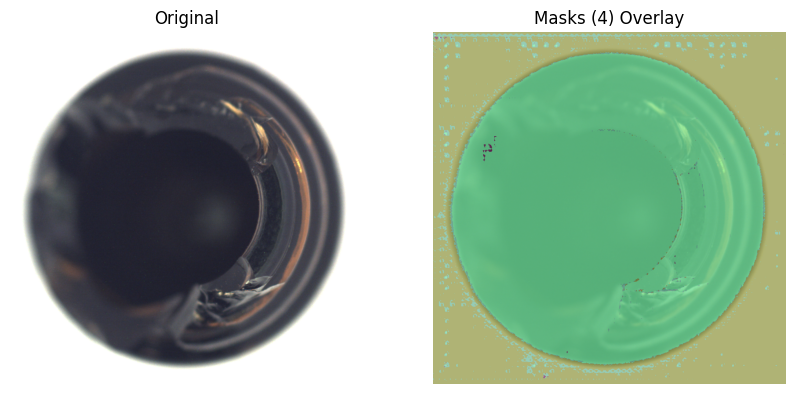

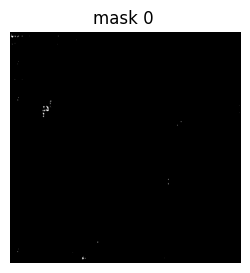

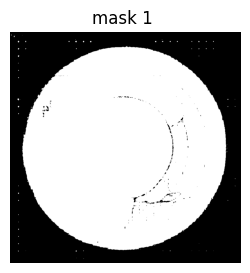

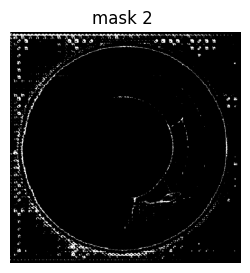

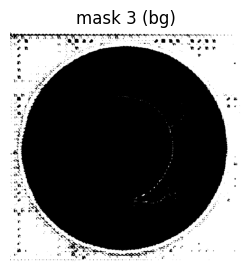

In [8]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
목적
  1) SAM-2 기본 설정 + 32-point grid 프롬프트
  2) 예측된 3개 마스크(Top-3 IoU score) + 배경 마스크 1장 → 총 4장
  3) 작은 마스크부터 겹침 제거 → overlap 0
  4) 배경 마스크로 coverage = 1.0
  5) 지표·시각화 즉시 확인
"""

# ───────────────────────────── 1. 라이브러리 ─────────────────────────────
import torch, cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# ───────────────────────────── 2. 경로 · 모델 ─────────────────────────────
IMG_PATH  = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/bottle/test/broken_large/003.png")   # 수정
CKPT_PATH = "./checkpoints/sam2.1_hiera_large.pt"
CFG_PATH  = "configs/sam2.1/sam2.1_hiera_l.yaml"

device = "cuda" if torch.cuda.is_available() else "cpu"
sam2   = build_sam2(CFG_PATH, CKPT_PATH, device=device).eval()    # 기본 파라미터
predictor = SAM2ImagePredictor(sam2)

# ───────────────────────────── 3. 이미지 로드 ────────────────────────────
img_bgr = cv2.imread(str(IMG_PATH)); assert img_bgr is not None
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
H, W, _ = img_rgb.shape
predictor.set_image(img_rgb)

# ───────────────────────────── 4. 32-Point Grid 프롬프트 ────────────────
GRID_SIZE = 32                   # 32개 포인트 (= 8×4)
gx, gy   = 8, 4
xs       = np.linspace(0, W - 1, gx)
ys       = np.linspace(0, H - 1, gy)
xv, yv   = np.meshgrid(xs, ys)
point_coords = np.stack([xv.flatten(), yv.flatten()], axis=1).astype(np.float32)
point_labels = np.ones(point_coords.shape[0], dtype=np.int32)     # 양성

# ───────────────────────────── 5. SAM2 예측 ─────────────────────────────
with torch.inference_mode(), torch.autocast(device_type="cuda", dtype=torch.bfloat16):
    masks, scores, _ = predictor.predict(
        point_coords=point_coords,
        point_labels=point_labels,
        multimask_output=True           # 포인트당 3개 → 96개 후보
    )

masks_np  = masks if isinstance(masks, np.ndarray) else masks.cpu().numpy()
scores_np = scores if isinstance(scores, np.ndarray) else scores.cpu().numpy()
masks_np  = masks_np.reshape(-1, H, W)         # (96, H, W)
scores_np = scores_np.flatten()                # (96,)

# ───────────────────────────── 6. Top-3 + 배경 마스크 ────────────────────
# 6-1. IoU score 기준 Top-3 선택
top3_idx  = np.argsort(-scores_np)[:3]
top_masks = masks_np[top3_idx].astype(bool)    # (3, H, W)

# 6-2. 작은 면적 우선 → 겹침 제거
areas     = top_masks.sum(axis=(1,2))
order     = np.argsort(areas)                  # asc
occupied  = np.zeros((H, W), dtype=bool)
final_fg  = []

for idx in order:
    m = np.logical_and(top_masks[idx], ~occupied)
    if m.sum():                                # 픽셀이 남아있다면
        final_fg.append(m)
        occupied |= m

# 6-3. 배경 마스크 추가
background = ~occupied
final_masks = final_fg + [background]

# ───────────────────────────── 7. 지표 계산 ──────────────────────────────
stack = np.stack(final_masks)                  # (4, H, W)
flat  = stack.reshape(4, -1)
coverage = flat.sum() / (H * W)
inter    = (flat[:, None] & flat).sum(-1)
area     = flat.sum(-1, keepdims=True)
iou_mat  = inter / (area + area.T - inter + 1e-6); np.fill_diagonal(iou_mat, 0)
mean_overlap = iou_mat.mean()

print(f"[INFO] final masks = 4 (fg 3 + bg 1)")
print(f"[METRIC] coverage      = {coverage:.3f}")   # 기대: 1.000
print(f"[METRIC] mean overlap  = {mean_overlap:.3f}")

# ───────────────────────────── 8. 시각화 ────────────────────────────────
palette = np.random.randint(0, 255, size=(4, 3))
overlay = img_rgb.copy()
for i, m in enumerate(final_masks):
    overlay[m] = overlay[m] * 0.3 + palette[i] * 0.7

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title("Original"); plt.imshow(img_rgb); plt.axis("off")
plt.subplot(1,2,2); plt.title("Masks (4) Overlay"); plt.imshow(overlay.astype(np.uint8)); plt.axis("off")
plt.show()

for i, m in enumerate(final_masks):
    plt.figure(figsize=(3,3)); plt.imshow(m, cmap="gray")
    plt.title(f"mask {i} {'(bg)' if i==3 else ''}")
    plt.axis("off")
    plt.show()


In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import yaml
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# --- 1. 모델 및 이미지 준비 ---
# 연구자님의 GCP 환경에 맞춰 GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# SAM2 모델 로드 (YAML 및 체크포인트 사용)
checkpoint_path = "./checkpoints/sam2.1_hiera_large.pt" # <-- 체크포인트 경로
model_cfg_path = "configs/sam2.1/sam2.1_hiera_l.yaml"  # <-- 설정 파일 경로

try:
    with open(model_cfg_path, 'r') as f:
        model_cfg = yaml.safe_load(f)
    
    predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint_path))
    print("SAM2ImagePredictor loaded successfully.")
    # 모델을 GPU로 이동
    predictor.model.to(device)

except (FileNotFoundError, ModuleNotFoundError) as e:
    print(f"Error loading model: {e}")
    print("Please ensure the checkpoint and config files are in the correct path and all dependencies are installed.")
    exit()

# MVTec-AD 데이터셋 이미지 로드 (예시 경로)
# 연구자님의 실제 데이터셋 경로로 수정해주세요.
image_path = '/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/bottle/test/broken_large/003.png' #  <-- 이 경로를 수정하세요!
try:
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        raise FileNotFoundError
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    print(f"Image loaded from: {image_path}")
except FileNotFoundError:
    print(f"Error: Image not found at '{image_path}'. Creating a dummy image.")
    image_rgb = np.zeros((512, 512, 3), dtype=np.uint8)
    cv2.circle(image_rgb, (256, 256), 100, (255, 0, 0), -1)


# --- 2. 비겹침 & 전체 커버리지 마스크 생성 함수 ---
def generate_partitioned_masks_with_predictor(predictor, image, points_per_side=32):
    """
    SAM2ImagePredictor와 포인트 그리드를 사용하여 비겹침 & 전체 커버리지 마스크를 생성합니다.
    """
    h, w, _ = image.shape
    
    # 1. 이미지 전체를 커버하는 포인트 그리드 생성
    print(f"Generating a {points_per_side}x{points_per_side} point grid...")
    grid_x = np.linspace(0, w - 1, points_per_side)
    grid_y = np.linspace(0, h - 1, points_per_side)
    xv, yv = np.meshgrid(grid_x, grid_y)
    point_grid = np.vstack([xv.ravel(), yv.ravel()]).T
    
    # 포인트 레이블 생성 (1: foreground point)
    point_labels = np.ones(point_grid.shape[0])

    # 2. 모든 포인트에 대해 마스크 예측 및 수집
    print("Predicting masks for all grid points...")
    all_masks = []
    
    # Autocast와 inference_mode를 사용하여 효율적으로 추론
    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
        # 이미지는 한 번만 설정
        predictor.set_image(image_rgb)
        
        # 각 포인트를 프롬프트로 사용하여 예측
        for point in point_grid:
            # 프롬프트를 torch 텐서로 변환
            pt_torch = torch.tensor([point], dtype=torch.float, device=device).unsqueeze(0)
            labels_torch = torch.tensor([1], dtype=torch.int, device=device).unsqueeze(0)
            
            masks, _, _ = predictor.predict(
                point_coords=pt_torch,
                point_labels=labels_torch,
                multimask_output=True, # 한 포인트에서 여러 마스크 후보를 얻음
            )
            # masks는 (num_masks, H, W) 형태의 torch 텐서
            all_masks.extend(masks.cpu().numpy())

    print(f"Generated {len(all_masks)} total candidate masks.")

    if not all_masks:
        inverted_mask = np.ones((h, w), dtype=bool)
        labeled_map = np.zeros((h, w), dtype=np.int32)
        return [], inverted_mask, labeled_map

    # 3. 우선순위 기반 파티셔닝 (이전과 동일한 로직)
    print("Partitioning masks based on area priority...")
    
    # 마스크와 면적 정보를 함께 저장 (중복 제거 효과도 일부 있음)
    mask_info_list = []
    unique_masks = {m.tobytes(): m for m in all_masks} # 바이트로 변환하여 중복 제거
    for mask_data in unique_masks.values():
        mask_info_list.append({'segmentation': mask_data, 'area': np.sum(mask_data)})
        
    sorted_masks = sorted(mask_info_list, key=lambda x: x['area'], reverse=True)

    labeled_map = np.zeros((h, w), dtype=np.int32)
    final_masks = []
    mask_id_counter = 1
    for mask_info in sorted_masks:
        mask_data = mask_info['segmentation']
        assign_area = (mask_data == True) & (labeled_map == 0)
        
        if np.any(assign_area):
            labeled_map[assign_area] = mask_id_counter
            final_masks.append(assign_area)
            mask_id_counter += 1

    inverted_mask = (labeled_map == 0)
    print("Partitioning complete.")

    return final_masks, inverted_mask, labeled_map


# 함수 실행
# points_per_side: 값을 높이면 더 세밀하게 탐색하지만 시간이 오래 걸립니다. 16~32 사이에서 시작하는 것을 추천합니다.
object_masks, inverted_mask, labeled_map = generate_partitioned_masks_with_predictor(predictor, image_rgb, points_per_side=32)

print(f"\nTotal partitioned object masks: {len(object_masks)}")
print(f"Inverted mask created: {np.any(inverted_mask)}")


# --- 3. 결과 시각화 (이전과 동일) ---
def visualize_results(original_image, object_masks, inverted_mask, labeled_map):
    num_masks_to_show = min(len(object_masks), 4)
    total_plots = 3 + num_masks_to_show
    fig, axes = plt.subplots(1, total_plots, figsize=(total_plots * 5, 5))
    fig.suptitle("SAM2ImagePredictor-based Partitioning", fontsize=16)
    
    axes[0].imshow(original_image); axes[0].set_title("Original Image"); axes[0].axis('off')
    axes[1].imshow(labeled_map, cmap='nipy_spectral'); axes[1].set_title("All Partitioned Masks"); axes[1].axis('off')
    axes[2].imshow(inverted_mask, cmap='gray'); axes[2].set_title("Inverted (Background) Mask"); axes[2].axis('off')
    
    for i in range(num_masks_to_show):
        axes[3+i].imshow(object_masks[i], cmap='gray'); axes[3+i].set_title(f"Object Mask #{i+1}"); axes[3+i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("\nVisualizing results...")
visualize_results(image_rgb, object_masks, inverted_mask, labeled_map)

Using device: cuda
Error loading model: [Errno 2] No such file or directory: 'configs/sam2.1/sam2.1_hiera_l.yaml'
Please ensure the checkpoint and config files are in the correct path and all dependencies are installed.
Image loaded from: /home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/bottle/test/broken_large/003.png


NameError: name 'predictor' is not defined